In [1]:
import torch
import sys
import numpy as np
import itertools
from models import ConvLSTM
from dataset import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import argparse
import time
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES'] = '2'


In [2]:
from flickerfusion.utils import *
from flickerfusion.attacks import LinfAttack, L2Attack

In [3]:
model_path = 'model_checkpoints/model_nodecay_30.pth'

In [4]:
device = "cuda"

In [5]:
# Define test set
test_dataset = Dataset(
    dataset_path="data/UCF-101-frames/",
    split_path="data/ucfTrainTestlist",
    split_number=1,
    input_shape=(3,224,224),
    sequence_length=40,
    training=False,
)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

/home/sangwooji/miniconda3/envs/colorfusion/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [6]:
# Define network
model = ConvLSTM(
    num_classes=101,
    latent_dim=512,
    lstm_layers=1,
    hidden_dim=1024,
    bidirectional=True,
    #attention=True,
)
model = model.to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

ConvLSTM(
  (encoder): Encoder(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)

In [56]:
# Check model accuracy
correct = total = 0
for batch_i, (X, y) in enumerate(test_dataloader):
    image_sequences = Variable(X.to(device), requires_grad=False)
    labels = Variable(y, requires_grad=False).to(device)
    with torch.no_grad():
        # Reset LSTM hidden state
        model.lstm.reset_hidden_state()
        # Get sequence predictions
        predictions = model(image_sequences)
        loss = 0
        # Update loss and prediction histogram at each timestep
        
    # Compute accuracy using the most common prediction for each sequence
    # Keep track of accuracy
    _, pred = predictions.max(1)
    correct += pred.eq(labels).sum().item()
    total += pred.shape[0]
    # Log test performance
    print(
        "\rTesting -- [Batch %d/%d], Acc: %.2f%%"
        % (batch_i, len(test_dataloader), correct/total)
        , end='\r'
    )


In [7]:
# Get videos with all frames, as a result, batch_size should be 1
test_dataset = Dataset(
    dataset_path="data/UCF-101-frames/",
    split_path="data/ucfTrainTestlist",
    split_number=1,
    input_shape=(3,224,224),
    sequence_length=None,
    training=False,
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [8]:
correct = total = 0
for batch_i, (images, labels) in enumerate(test_dataloader):
    break
images = images.to(device)
labels = labels.to(device)

In [ ]:
sequence_length = 40
sample_interval = np.random.randint(1, video_len // sequence_length + 1)
start_i = np.random.randint(0, video_len - sample_interval * sequence_length + 1)

In [35]:
# validate color conversion in 5-dim tensor
with torch.no_grad():
    src_lrgb = rgb2lrgb(images)
    src_xyY = rgb2xyY(images)

In [10]:
images.shape

torch.Size([1, 164, 3, 224, 224])

In [115]:
p = torch.ones(3,224,224)

In [146]:
video = images.clone()[0]

In [147]:
for i, image in enumerate(video):
    if i % 2 == 0:
        image += p
    else:
        image -= p

In [152]:
video.shape

torch.Size([164, 3, 224, 224])

In [25]:
input_size = 224
adv_perturbation = torch.zeros((input_size,input_size,2)).to(device)
adv_perturbation.requires_grad = True
expand_to_lrgb = torch.Tensor([[1, 0],[-0.2126/0.7152, -0.0722/0.7152],[0,1]]).T.to(device)

In [26]:
l_perturbation = torch.matmul(adv_perturbation,expand_to_lrgb).permute(2,0,1)

In [27]:
video_lrgb = rgb2lrgb(images[0])

In [28]:
video_lrgb.shape

torch.Size([164, 3, 224, 224])

In [29]:
nb_proj = 1

# add perturbation
p_proj = project_perturbation(video_lrgb, l_perturbation, nb_proj)

temp = video_lrgb + p_proj
p_plus = torch.clamp(temp, 0, 1)
idx_plus = p_plus != temp
p_plus = p_plus - video_lrgb

temp = video_lrgb - p_proj
p_minus = torch.clamp(temp, 0, 1)
idx_minus = p_minus != temp
p_minus = video_lrgb - p_minus

p_clipped = torch.where(p_plus.abs() > p_minus.abs(), p_minus, p_plus)
p_clipped = torch.where(idx_plus | idx_minus, p_clipped, p_proj)
l_perturbation = p_clipped

In [ ]:
# This approach seems feasible

In [11]:
nb_proj=1

In [12]:
video = rgb2lrgb(images).clone()[0]
# add perturbation
p_proj = project_perturbation(video, l_perturbation, nb_proj)
for i, image in enumerate(video):
    if i % 2 == 0:
        image = image + p_proj[i]
    else:
        image = image - p_proj[i]
clipped = torch.clamp(video, 0, 1)

# sample
sequence_length = 40
video_len = len(clipped)
sample_interval = np.random.randint(1, video_len // sequence_length + 1)
start_i = np.random.randint(0, video_len - sample_interval * sequence_length + 1)

adv_video = []
for i in range(start_i, start_i + sequence_length*sample_interval, sample_interval):
    adv_video.append(clipped[i])
adv_video = torch.stack(adv_video)

In [13]:
adv_video.shape

torch.Size([40, 3, 224, 224])

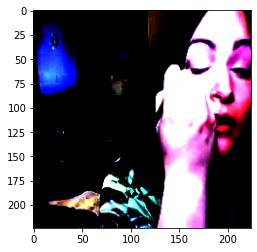

In [14]:
plt.imshow(adv_video[0].cpu().permute(1,2,0))

In [17]:
batch_size = 1
input_size = 224
mask_range = input_size
mask_size = int(mask_range * 0.2)
t = torch.arange(0, mask_range, device=device).repeat(batch_size,1)
pad = 30

In [18]:
start_row = torch.randint(low=pad, high=mask_range-mask_size-pad, \
                          size=(batch_size,1), device=device)

start_row

tensor([[141]], device='cuda:0')

In [19]:
mask = t.ge(start_row) & t.lt(start_row+mask_size)
mask.shape

torch.Size([1, 224])

In [20]:
start_row = torch.randint(low=pad, high=mask_range-mask_size-pad, \
                          size=(batch_size,1), device=device)
mask = t.ge(start_row) & t.lt(start_row+mask_size)
l_perturbation[mask.reshape(1,input_size,1).repeat(3,1,input_size)] = 0


In [39]:
class LRGBLum0Attack():
    """
    LRGB attack in Luminance 0 plane
    """        
    def perturb(self, net, images, labels, config, device, targeted=False, verbose=False, aug=None):
        net.eval()
        net.lstm.train()
        net.attention_layer.train()
        batch_size = 1
        
        # adv_perturbation: lrgb [224, 224, 2]  
        input_size = 224
        adv_perturbation = torch.zeros((input_size,input_size,2)).to(device)
        adv_perturbation.requires_grad = True
        expand_to_lrgb = torch.Tensor([[1, 0],[-0.2126/0.7152, -0.0722/0.7152],[0,1]]).T.to(device)

        mask_range = input_size
        mask_size = int(mask_range * config['row_mask_rate'])
        t = torch.arange(0, mask_range, device=device).repeat(batch_size,1)
        pad = config['row_mask_pad']
        
        loss_sum = 0
        save_iter = config['save_iter']
        coeff_xy = config['coeff_xy']
        nb_proj = config['nb_proj']
        if coeff_xy >= 0:
            mseloss = torch.nn.MSELoss()
        for i in range(self.nb_iter):
#             video = images.clone()[0]
            video_lrgb = rgb2lrgb(images[0])
            net.zero_grad()
            
#           # expand perturbation
            l_perturbation = torch.matmul(adv_perturbation,expand_to_lrgb).permute(2,0,1)
                
            # Random intensity
            weight = torch.rand(1).to(device)
            l_perturbation = (weight*config['rand_weight']+config['rand_base'])*l_perturbation
            
            # Row masking
            start_row = torch.randint(low=pad, high=mask_range-mask_size-pad, \
                                      size=(batch_size,1), device=device)
            mask = t.ge(start_row) & t.lt(start_row+mask_size)
            l_perturbation[mask.reshape(1,input_size,1).repeat(3,1,input_size)] = 0

            # add perturbation
            p_proj = project_perturbation(video_lrgb, l_perturbation, nb_proj)

            temp = video_lrgb + p_proj
            p_plus = torch.clamp(temp, 0, 1)
            idx_plus = p_plus != temp
            p_plus = p_plus - video_lrgb

            temp = video_lrgb - p_proj
            p_minus = torch.clamp(temp, 0, 1)
            idx_minus = p_minus != temp
            p_minus = video_lrgb - p_minus

            p_clipped = torch.where(p_plus.abs() > p_minus.abs(), p_minus, p_plus)
            p_clipped = torch.where(idx_plus | idx_minus, p_clipped, p_proj)
            l_perturbation = p_clipped
            
            # plus, minus, mixed
            adv_minus = lrgb2rgb(torch.clamp(video_lrgb - l_perturbation, 0, 1))
            adv_plus = lrgb2rgb(torch.clamp(video_lrgb + l_perturbation, 0, 1))

            # sample
            sequence_length = 40
            video_len = len(video_lrgb)
            sample_interval = np.random.randint(1, video_len // sequence_length + 1)
            start_i = np.random.randint(0, video_len - sample_interval * sequence_length + 1)

            adv_video = []
            for i in range(start_i, start_i + sequence_length*sample_interval, sample_interval):
                if i % 2 == 0:
                    adv_video.append(adv_plus[i])
                else:
                    adv_video.append(adv_minus[i])
            adv_video = torch.stack(adv_video)
            
            adv_video = lrgb2rgb(adv_video)
            if aug is not None:
                adv_aug = aug(adv_video)
            else:
                adv_aug = adv_video
                
            print (adv_aug.unsqueeze(0).shape)
            outputs = net(adv_aug.unsqueeze(0))
            
            loss_ce = self.loss_fn(outputs, labels)
            
            if coeff_xy >= 0:
                video_xyY = rgb2xyY(images)
                plus_xyY = rgb2xyY(adv_plus)
                minus_xyY = rgb2xyY(adv_minus)
                merged_xyY = (plus_xyY + minus_xyY) / 2
                loss_xy = mseloss(merged_xyY, rgb2xyY(video_xyY))
                
            loss = loss_ce + coeff_xy * loss_xy
            loss.backward()

            grad = self._get_perturb(adv_perturbation.grad.detach())
            if targeted >= 0:
                adv_perturbation.data = adv_perturbation.data - self.eps_iter * grad
            else:
                adv_perturbation.data = adv_perturbation.data + self.eps_iter * grad
            adv_perturbation.data = self._projection(adv_perturbation.data, 1)
            adv_perturbation.grad.data.zero_()
            
            print ("iter %d: l_ce, l_xy %.5f, loss %.5f" % \
                   (i, loss_ce.item(), coeff_xy*loss_xy.item(), loss.item()), end='\r')
            loss_sum += loss.item()
                
#             if (i+1) % save_iter == 0:
#                 file_name = '%s_%d.npy' % (config['file_name'], (i+1))
#                 np.save(config['file_dir'] + file_name, torch.matmul(adv_perturbation,expand_to_lrgb).permute(0,3,1,2).detach().cpu())
#                 print (datetime.datetime.now(), \
#                        'save the perturbation at %dth iterations' % (i+1))
                
#         file_name = '%s_%d.npy' % (config['file_name'], (i+1))
#         np.save(config['file_dir'] + file_name, torch.matmul(adv_perturbation,expand_to_lrgb).permute(0,3,1,2).detach().cpu())
#         print (datetime.datetime.now(), \
#                'save the perturbation at %dth iterations' % (i+1))
        return torch.matmul(adv_perturbation,expand_to_lrgb).permute(0,3,1,2).detach()

In [40]:

# Attack base class
class LinfAttack():
        
    def _rand_init(self, image):
        #     np.random.uniform(low=-self.eps, high=self.eps, size=image.shape)
        return image + torch.zeros_like(image).uniform_(-self.eps, self.eps)
    
    def _get_perturb(self, grad):
        return torch.sign(grad)
    
    def _projection(self, perturbation, budget):
        return torch.clamp(perturbation, -budget, budget)
    
class LinfLRGBLum0Attack(LRGBLum0Attack, LinfAttack):
    def __init__(self, loss_fn, eps, nb_iter, eps_iter, 
                 rand_init, clip_min, clip_max):
        self.loss_fn = loss_fn
        self.eps = eps
        self.nb_iter = nb_iter
        self.eps_iter = eps_iter
        self.rand_init = rand_init
        self.clip_min = clip_min
        self.clip_max = clip_max

In [41]:
attack = LinfLRGBLum0Attack(torch.nn.CrossEntropyLoss(), eps=0.1, nb_iter=5, eps_iter=0.1, rand_init=False, clip_min=0, clip_max=0)

In [42]:
config = {}
config['row_mask_rate'] = 0
config['row_mask_pad'] = 0
config['rand_weight'] = 0
config['rand_base'] = 0
config['save_iter'] = 0
config['coeff_xy'] = 0 
config['nb_proj'] = 1
attack.perturb(model, images, labels.to(device), config=config, device='cuda')

torch.Size([1, 40, 3, 224, 224])


/home/sangwooji/miniconda3/envs/colorfusion/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 164, 3, 224, 224])) that is different to the input size (torch.Size([164, 3, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling .backward() or autograd.grad() the first time.

In [38]:
model

ConvLSTM(
  (encoder): Encoder(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)

In [33]:
model.lstm.training

True

In [ ]:
# Old version
class LRGBLum0Attack():
    """
    LRGB attack in Luminance 0 plane
    """        
    def perturb(self, net, images, labels, config, device, targeted=False, verbose=False, aug=None):
        net.eval()
        batch_size = 1
        
        # adv_perturbation: lrgb [224, 224, 2]  
        input_size = 224
        adv_perturbation = torch.zeros((input_size,input_size,2)).to(device)
        adv_perturbation.requires_grad = True
        expand_to_lrgb = torch.Tensor([[1, 0],[-0.2126/0.7152, -0.0722/0.7152],[0,1]]).T.to(device)

        mask_range = input_size
        mask_size = int(mask_range * config['row_mask_rate'])
        t = torch.arange(0, mask_range, device=device).repeat(batch_size,1)
        pad = config['row_mask_pad']
        
        loss_sum = 0
        save_iter = config['save_iter']
        coeff_xy = config['coeff_xy']
        nb_proj = config['nb_proj']
        if coeff_xy >= 0:
            mseloss = torch.nn.MSELoss()
        for i in range(self.nb_iter):
            video = images.clone()[0]
            video_lrgb = rgb2lrgb(video)
            net.zero_grad()
            
#           # expand perturbation
            l_perturbation = torch.matmul(adv_perturbation,expand_to_lrgb).permute(2,0,1)
                
            # Random intensity
            weight = torch.rand(1).to(device)
            l_perturbation = (weight*config['rand_weight']+config['rand_base'])*l_perturbation
            
            # Row masking
            start_row = torch.randint(low=pad, high=mask_range-mask_size-pad, \
                                      size=(batch_size,1), device=device)
            mask = t.ge(start_row) & t.lt(start_row+mask_size)
            l_perturbation[mask.reshape(1,input_size,1).repeat(3,1,input_size)] = 0

            # add perturbation
            p_proj = project_perturbation(video_lrgb, l_perturbation, nb_proj)
            for i, image in enumerate(video_lrgb):
                if i % 2 == 0:
                    image = image + p_proj[i]
                else:
                    image = image - p_proj[i]
            clipped = torch.clamp(video_lrgb, 0, 1)

            # sample
            sequence_length = 40
            video_len = len(clipped)
            sample_interval = np.random.randint(1, video_len // sequence_length + 1)
            start_i = np.random.randint(0, video_len - sample_interval * sequence_length + 1)

            adv_video = []
            for i in range(start_i, start_i + sequence_length*sample_interval, sample_interval):
                adv_video.append(clipped[i])
            adv_video = torch.stack(adv_video)
            
            adv_video = lrgb2rgb(adv_video)
            if aug is not None:
                adv_aug = aug(adv_video)
            else:
                adv_aug = adv_video
            outputs = net(adv_aug)
            
            loss_ce = self.loss_fn(outputs, labels)
            
            if coeff_xy >= 0:
                video_compen = images.clone()[0]
                for i, image in enumerate(video_compen):
                    if i % 2 == 0:
                        image = image - p_proj[i]
                    else:
                        image = image + p_proj[i]
                video_compen = torch.clamp(video_compen, 0, 1)
                
                plus_xyY = rgb2xyY(adv_video)
                minus_xyY = lrgb2xyY(video_compen)
                merged_xyY = (plus_xyY + minus_xyY) / 2
                loss_xy = mseloss(merged_xyY, rgb2xyY(video))
                
            loss = loss_ce + coeff_xy * loss_xy
            loss.backward()

            grad = self._get_perturb(adv_perturbation.grad.detach())
            if targeted >= 0:
                adv_perturbation.data = adv_perturbation.data - self.eps_iter * grad
            else:
                adv_perturbation.data = adv_perturbation.data + self.eps_iter * grad
            adv_perturbation.data = self._projection(adv_perturbation.data, 1)
            adv_perturbation.grad.data.zero_()
            
            print ("iter %d: l_ce, l_xy %.5f, loss %.5f" % \
                   (i, loss_ce.item(), coeff_xy*loss_xy.item(), loss.item()), end='\r')
            loss_sum += loss.item()
                
#             if (i+1) % save_iter == 0:
#                 file_name = '%s_%d.npy' % (config['file_name'], (i+1))
#                 np.save(config['file_dir'] + file_name, torch.matmul(adv_perturbation,expand_to_lrgb).permute(0,3,1,2).detach().cpu())
#                 print (datetime.datetime.now(), \
#                        'save the perturbation at %dth iterations' % (i+1))
                
#         file_name = '%s_%d.npy' % (config['file_name'], (i+1))
#         np.save(config['file_dir'] + file_name, torch.matmul(adv_perturbation,expand_to_lrgb).permute(0,3,1,2).detach().cpu())
#         print (datetime.datetime.now(), \
#                'save the perturbation at %dth iterations' % (i+1))
        return torch.matmul(adv_perturbation,expand_to_lrgb).permute(0,3,1,2).detach()